# Robot Juggling Demo

In this final section we will program the robot to juggle the ball to bounce with a desired periodic motion. 

In [1]:
from tutorial import * 
play_full_solution()

If a window pops up like this picture then you have successfully run the demo. 

<img width="50%" src="media/robo_juggle.gif"/>

# Robot Juggling

Now that we have a controller for the robot, we are going to focus on the problem of robot juggling.  First, we will look at the dynamics of the ball before thinking about how to control it.


**Ball dynamics (projectile)**

During free flight the only force acting upon the ball is gravity


$$y = y_0 + v_{y_0}\cdot t - \frac{1}{2}g\cdot t^2 $$

Let's see how well this modesl the ball's flight in our simulator.  What happens if the restitution is not equal to 0?

**Ball dynamics (collisions)**

When the restitution is greater than 0.  The initial velocity after impact is scaled by the restitution factor and inverted:
$$\dot{y}_{initial + 1} = -C_{r}\cdot \dot{y}_{impact}$$


moving robot far away


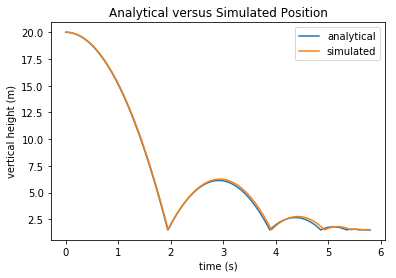

In [4]:
import tutorial; reload(tutorial); from tutorial import * ; 

initial_pose = (16, 20, 0)
restitution = 0.5
result = run_ball_dynamics(ball_pose=initial_pose,  restitution=restitution)
plot_analytical_vs_sim(result, restitution)


## Environmental Control

The environmental control system models the dynamics of the ball given abstract robot actions $u = u_1, u_2$, where 

* $u_1$: models where the robot should hit the ball

* $u_2$: the amount of linear velocity the impact should have

The state of the ball is modeled as $ w = (w_1, w_2)  $, where $w_1 = (b_x, b_y)$ and $w_2 = (\dot{b}_x, \dot{b}_y)$

The ball dynamics *at impact* can be modeled as:

$$
\dot{w} = 
\dot{
\begin{bmatrix}
b_x & b_y\\
\dot{b}_x & \dot{b}_y
\end{bmatrix}
}
=
\begin{bmatrix}
1 & 0 \\
0 & -C
\end{bmatrix}
\begin{bmatrix}
b_x & b_y\\
\dot{b}_x & \dot{b}_y
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\
1 + C & 1 + C
\end{bmatrix}
\begin{bmatrix}
u_{1x} & u_{1y}\\
u_{2x} & u_{2y}
\end{bmatrix}
$$

The impact dynamics are in the form:
$$
\dot{X} = AX + BU 
$$

We can choose a proportional controller $U = KX$,  Then the impact dynamics are in the form:
$$
\dot{X} = AX + BKX
$$
$$
\dot{X} = (A + BK)X
$$
The system is stable when the real components of the characteristic equation are less than 0:
$$ RE(\ det((A+BK) - \lambda I)\ ) < 0$$

The last question is setting the desired hit location and impact velocity.  To determine the desired velocity we can look at the potential and kinetic energy in the system:

$$mv_f - mv_i = mgh_f - mgh_i $$

Since the initial velocity is 0 (ball is dropped from rest) we can compute the desired velocity given the impact location and desired peak impact height.

moving robot far away


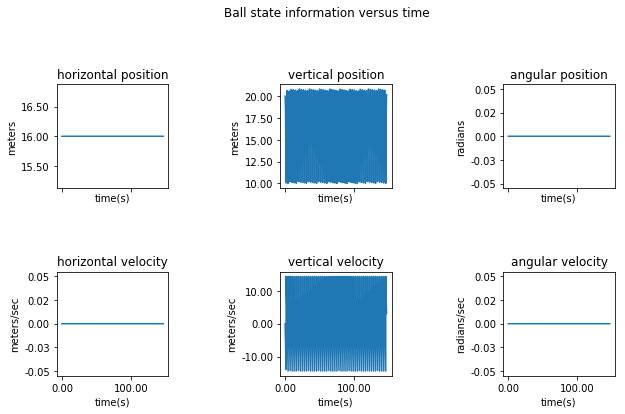

In [5]:
import tutorial; reload(tutorial); from tutorial import * ; 

initial_pose = (16, 20, 0)
C = .5 # restitution
c_x = initial_pose[0]
impact_height = 10
peak_height = 20


delta_flight = peak_height - impact_height

# desired ball state
w_d =np.array([
    [c_x, impact_height],
    [0, (2*9.81*delta_flight)**0.5 ]
    ])

K = .08*np.array( [ [0, 1], [0, 1]])

def ball_controller(time, ball_state):
    
    bx,by,bth,bxdot,bydot,bthdot = ball_state
    w = np.array([[bx,by], [bxdot,bydot]])
    u =  K*(w_d - w ) 
    
    px = 0
    py = 0 
    pth = 0
    
    # only apply impact near desired hit location:
    if np.all(np.abs(w_d[0] -w[0]) < .2 ):
        px,py = u[1]
        
    return px, py, pth 


result = run_ball_dynamics(ball_pose=initial_pose,  \
                           restitution=C, \
                           ball_controller=ball_controller, \
                           peak_goal = peak_height,
                           impact_goal = impact_height)
plot(result, "Ball")


# Environmental control with a reference signal
We can augment our controller to prevent steady state error.
To do this we provide a reference signal for the desired environmental control state.  



moving robot far away


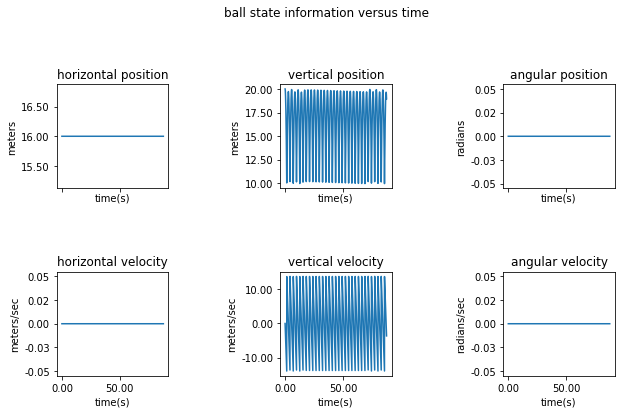

In [9]:
import tutorial; reload(tutorial); from tutorial import * ; 

ball_pose = (16, 20, 0)
C = .5 # restitution
impact_height = 10
peak_height = 20
ball_mass = 0.0785398185253

c_x = ball_pose[0]
delta_flight = peak_height - impact_height

# desired ball state
w_1 = [c_x, impact_height]
w_2 = [0, (2*9.81*delta_flight)**0.5 ]
w_d = np.array([w_1, w_2])

#desired environment control state
u_d = np.array([w_1, [0, ball_mass*w_2[1]*(1-C)/(1+C)] ])

K = .065*np.array( [ [0, 1], [0, 1]])

def ball_controller(time, ball_state):
    
    bx,by,bth,bxdot,bydot,bthdot = ball_state
    w_1 = [bx, by]
    w_2 = [bxdot, bydot]
    w = np.array([w_1, w_2])
    

    u =  K*(w_d - w ) + u_d
    
    px = 0
    py = 0 
    pth = 0
    
    # change where to hit ball
    if np.all(np.abs(u[0] -w[0]) < .2 ):
        px,py = u[1]
    return px, py, pth 



result = run_ball_dynamics(ball_pose=initial_pose,  \
                           restitution=C, \
                           ball_controller=ball_controller, \
                           peak_goal = peak_height, \
                           impact_goal = impact_height)
plot(result, "ball")


# A simple robot catch

Now we are going to put everything together to implement a mirror control law, where the robot mirrors the ball. At every time step, the position of the robot is:

* $r_x = b_x$
* $r_y = -k_cb_y$
* $r_{th} = b_{th} = 0$

where $k_c= (1 - C) / ( 1 + c)$

For this first part, we will implement a catch where 
* $\dot{r}_x = 0$
* $\dot{r}_y = 0 $
* $\dot{r}_th = 0 $




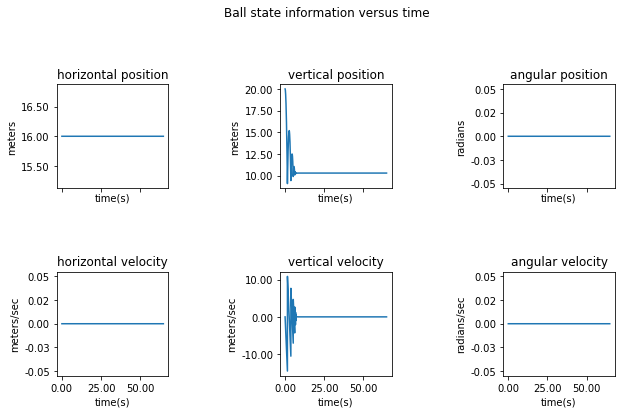

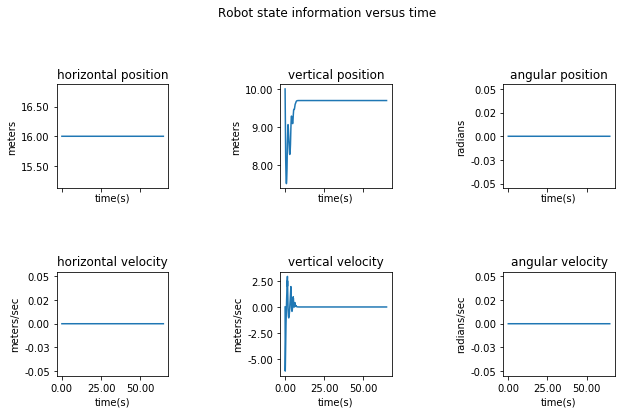

In [10]:
import tutorial; reload(tutorial); from tutorial import * ; 

ball_pose = (16, 20, 0)
C = .5 # restitution
impact_height = 10



cx = ball_pose[0]
cy = impact_height
robot_pose = (16, impact_height, 0)


def closedLoopController (time, robot_state, desired_pose, desired_vel):
    """
    The closed loop pd-controller for the robot paddle implemented
    in the previous section.
    """
    
    K_px = 100
    K_py = 100
    K_pth = 10
    K_dx = 50
    K_dy = 50
    K_dth = 20

    
    # the output signal
    x,y,th, xdot, ydot, thdot = robot_state
    
    # the reference signal
    rx, ry, rth = desired_pose 
    rxdot, rydot, rthdot = desired_vel
    
    # the error signal
    e_x = rx - x
    e_y = ry - y
    e_th = rth - th

    e_xdot = rxdot - xdot
    e_ydot = rydot - ydot
    e_thdot = rthdot - thdot
    
    # the controller output
    u_x = K_px*e_x + K_dx*e_xdot
    u_y = K_py*e_y + K_dy*e_ydot
    u_th = K_pth*e_th + K_dth*e_thdot
    
    return u_x, u_y, u_th 

def robot_controller(time, robot_state, ball_state):
    """
    A catching controller.  The robot mirrors the movement
    of the ball.
    """
    bx,by,bth,bxdot,bydot,bthdot = ball_state
    k_c = (1-C)/(1+C)
    rx = cx + (bx - cx)
    ry = cy - k_c*(by - cy)
    rth = 0
    rxdot = 0
    rydot = 0
    rthdot = 0
    desired_pose = (rx, ry, rth)
    desired_vel = (rxdot, rydot, rthdot)
    return closedLoopController(time, robot_state, desired_pose, desired_vel)
    
    

result = run_ball_dynamics(ball_pose=ball_pose,  \
                           robot_pose = robot_pose, \
                           restitution=C, \
                           robot_controller=robot_controller, \
                           impact_goal = impact_height)

plot([result[0], result[1]], 'Ball')
plot([result[0], result[2]], 'Robot')


# A simple robot juggler

We could try extending the mirror control law for juggling by setting the robot's vertical velocity to mirror the ball's vertical velocity:

* $\dot{r}_x = 0$
* $\dot{r}_y = -k_c \cdot b_y $
* $\dot{r}_{th} = 0 $




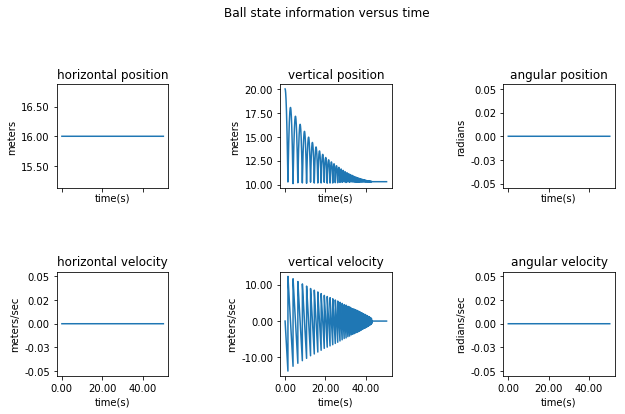

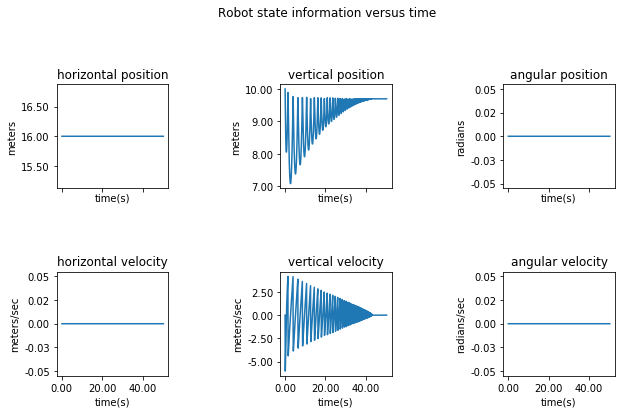

In [11]:
import tutorial; reload(tutorial); from tutorial import * ; 

ball_pose = (16, 20, 0)
C = .5 # restitution
impact_height = 10

cx = ball_pose[0]
cy = impact_height
robot_pose = (16, impact_height, 0)


def robot_controller(time, robot_state, ball_state):
    """
    A catching controller.  The robot mirrors the movement
    of the ball.
    """
    bx,by,bth,bxdot,bydot,bthdot = ball_state
    k_c = (1-C)/(1+C)
    rx = cx + (bx - cx)
    ry = cy - k_c*(by - cy)
    rth = 0
    rxdot = 0
    rydot = -k_c*bydot
    rthdot = 0
    desired_pose = (rx, ry, rth)
    desired_vel = (rxdot, rydot, rthdot)
    return closedLoopController(time, robot_state, desired_pose, desired_vel)
    
    

result = run_ball_dynamics(ball_pose=ball_pose,  \
                           robot_pose = robot_pose, \
                           restitution=C, \
                           robot_controller=robot_controller, \
                           peak_goal = peak_height, \
                           impact_goal = impact_height)

plot([result[0], result[1]], 'Ball')
plot([result[0], result[2]], 'Robot')


# An improved robot juggler

The simple juggler works pretty well, but eventually the ball dynamics don't match our simplified model of the impact dynamics.  The energy in the system goes to 0.

To account for this loss, we can modify our gain to be proportional to the vertical energy in the system:

$$n(b_y, \dot{b}_y) = \frac{1}{2}\cdot{b}_y^2 + g\cdot b_y$$

Our desired energy can be computed from the peak and impact heights:

$$n_d = g\cdot (b_{peak} - b_{impact})$$

The following is the distorted mirror control law:

$$ r_y = - \{k_c + k_e[n_d - n(b_y, \dot{b}_y)] \}b _y $$
$$ r_y = -K(w)b_y $$

where $k_c= (1 - C) / ( 1 + c)$ and $k_e$ is the energy error gain

Since we are not modeling friction in the impact model $\dot{n}$ = 0 and 
$$ \dot{r}_y = -K(w)\dot{b}_y $$.




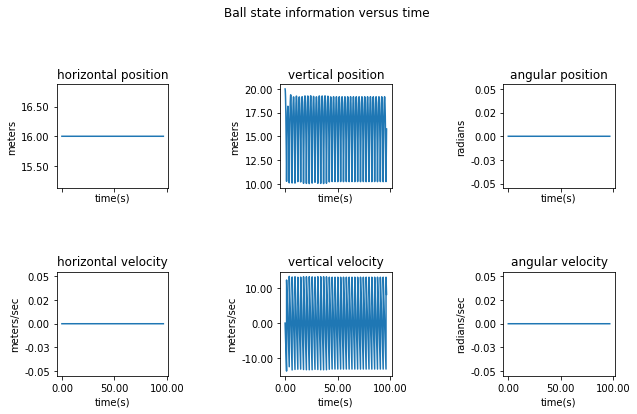

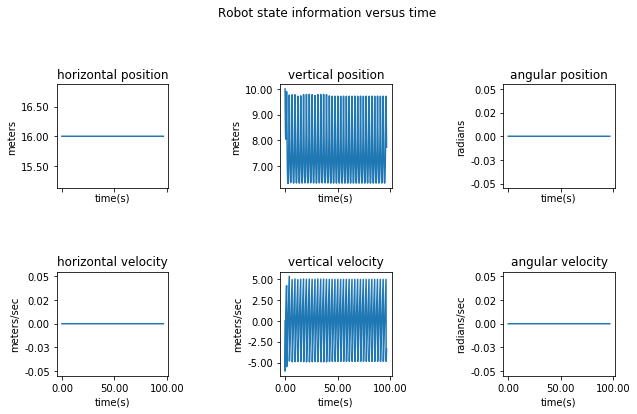

In [12]:
import tutorial; reload(tutorial); from tutorial import * ; 

def vertical_energy(b_y, b_ydot):
    return 0.5*b_ydot**2 + 9.81*b_y


ball_pose = (16, 20, 0)
C = .5 # restitution
impact_height = 10
peak_height = 20

cx = ball_pose[0]
cy = impact_height
robot_pose = (16, impact_height, 0)

k_e = .005
k_c = (1-C)/(1+C)

n_d = vertical_energy(peak_height-impact_height, 0)


def robot_controller(time, robot_state, ball_state):
    """
    A catching controller.  The robot mirrors the movement
    of the ball.
    """
    bx,by,bth,bxdot,bydot,bthdot = ball_state
    
    n_curr = vertical_energy(by-cy, bydot)
    
    kw = k_c + k_e*(n_d - n_curr)

    rx = cx + (bx - cx)
    ry = cy - kw*(by - cy)
    rth = 0
    rxdot = 0
    rydot = -kw*bydot
    rthdot = 0
    desired_pose = (rx, ry, rth)
    desired_vel = (rxdot, rydot, rthdot)
    return closedLoopController(time, robot_state, desired_pose, desired_vel)
    
    

result = run_ball_dynamics(ball_pose=ball_pose,  \
                           robot_pose = robot_pose, \
                           restitution=C, \
                           robot_controller=robot_controller, \
                           peak_goal = peak_height, \
                           impact_goal = impact_height)

plot([result[0], result[1]], 'Ball')
plot([result[0], result[2]], 'Robot')
